In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob as gb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (16, 9)

In [2]:
#PERF_DIR = Path('/Users/julien/Software/Others/OS-build-release/results/')

In [3]:
#csvs = list(PERF_DIR.glob('*.csv'))

In [4]:
# 3.5.1 official versus https://github.com/NREL/OpenStudio/pull/4532
csvs = list(Path('build-351/results/').glob('*csv')) + list(Path('build-perf/results/').glob('*csv'))

In [5]:
csv = csvs[0]

In [6]:
def find_skip_rows(results_file: Path) -> int:
    """
    Open the result benchmark, and locate the actual start of the timings

    Returns:
    --------
    skiprows (int): the number of lines to skip when read_csv is called
    """
    skiprows = 0
    search_str = 'name,iterations,'
    with open(results_file, 'r') as f:
        content = f.read()
    if search_str not in content:
        return None
    lines = content.splitlines()
    while (search_str not in lines[skiprows]):
        skiprows += 1

    return skiprows

In [7]:
def read_bench_results(results_file: Path) -> pd.DataFrame:
    skiprows = find_skip_rows(csv)
    if skiprows is None:
        return None
    df = pd.read_csv(csv, skiprows=skiprows, index_col=0)
    df = df.loc[df['iterations'].notnull()]
    # Convert everything in ms
    for col in ['real_time', 'cpu_time']:
        df[col] = (df[[col, 'time_unit']].apply(
            lambda row: pd.to_timedelta(arg=row[0], unit=row[1]), axis=1)
                   .dt.total_seconds() * 1e3)
        
    return df

In [8]:
df_dict = {}
dfs = []
for csv in csvs:
    fname = csv.name
    #if 'Model_ModelObjects' in fname:
    #    fname = 'Model_ModelObjects'
    prefix  = Path(csv).name.split('_')[0]
    test = '_'.join(fname.split('_')[1:-1])
    
    df = read_bench_results(csv)
    if df is None:
        continue
    df['test_file'] = test
    df['prefix'] = prefix
    dfs.append(df)
    
df = pd.concat(dfs, axis=0)
df.set_index(['prefix', 'test_file'], append=True, inplace=True)
df_real = df['real_time'].unstack('prefix')

In [9]:
df_real = df_real[['ori', 'new']]

In [10]:
df_real.index.size

145

In [11]:
df_real = df_real.loc[[x for x in df_real.index if not x[1] == 'Model_ModelObjects' or not 'Proposed' in x[0]]]
df_real.index.size

115

In [12]:
df_real.sum(axis=0).sort_values()

prefix
new     87426.879050
ori    101884.090724
dtype: float64

In [13]:
total = df_real.sum(axis=0).sort_values()
total_new = total['new']
total_ori = total['ori']
print(f"Total runtime:")
print(f"* ori: {total_ori:,.0f} ms")
print(f"* new: {total_new:,.0f} ms")
print(f"* Difference: {total_new / total_ori - 1:.2%}")

Total runtime:
* ori: 101,884 ms
* new: 87,427 ms
* Difference: -14.19%


In [14]:
df_sum = df_real[df_real['ori'].notnull()].groupby('test_file').sum()
df_sum['difference'] = df_sum['new'].divide(df_sum['ori']) - 1
df_sum.style.format("{:.0f}").format("{:.2%}", subset='difference').set_caption("Runtime, ms")

prefix,ori,new,difference
test_file,,,
ForwardTranslator,41688,37388,-10.32%
IddObjectParse,0,0,2.75%
IdfFileGetObjects,0,0,-0.73%
IdfObjectParse,0,0,0.47%
LoadIdd,117,117,0.13%
LoadIdfFile,191,191,-0.13%
Model,42995,40120,-6.69%
Model_ModelObjects,0,0,-5.82%
ThermalZoneCombineSpaces,8730,1520,-82.59%


<AxesSubplot:ylabel='name'>

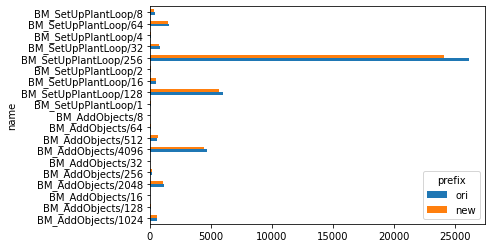

In [15]:
df_real.swaplevel(0, 1, axis=0).loc['Model', ['ori', 'new']].plot(kind='barh')

# Plot the interesting stuff that is size dependent

In [16]:
cols = ['ori', 'new']

In [17]:
test_files = ['ThermalZoneCombineSpaces', 'Model_ModelObjects', 'Model',
         'Vector_remove_vs_copy', 'Workspace', 'ForwardTranslator']

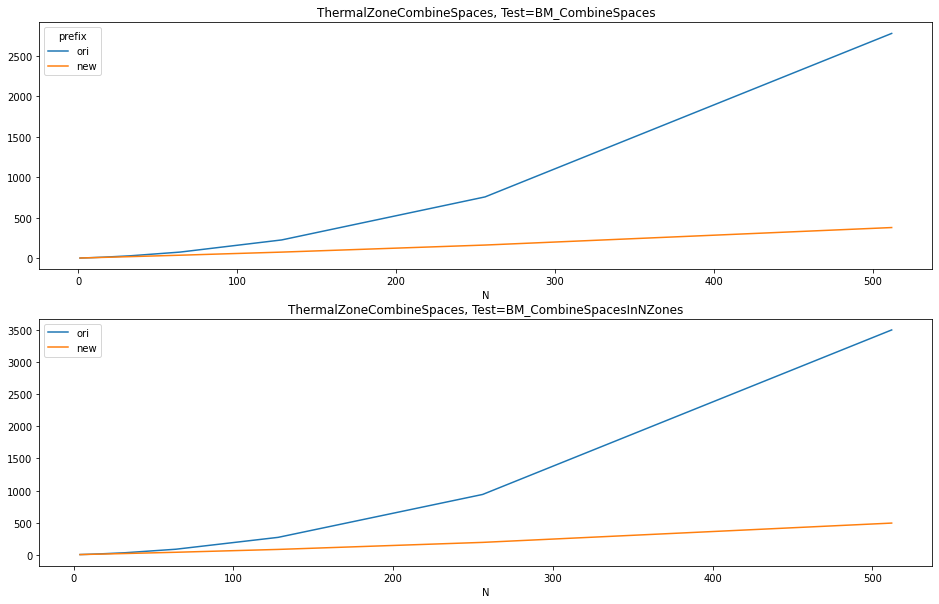

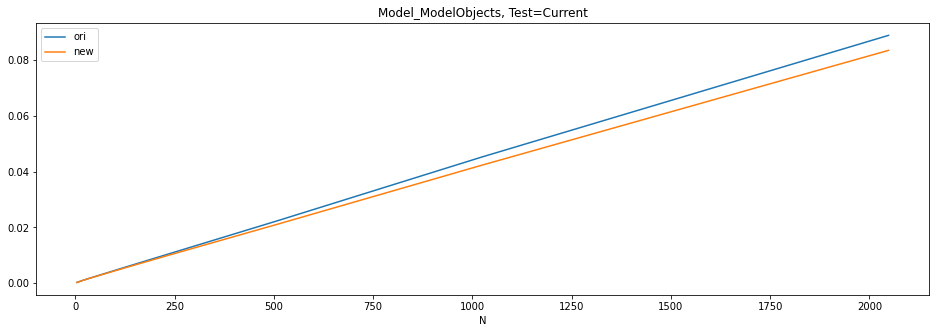

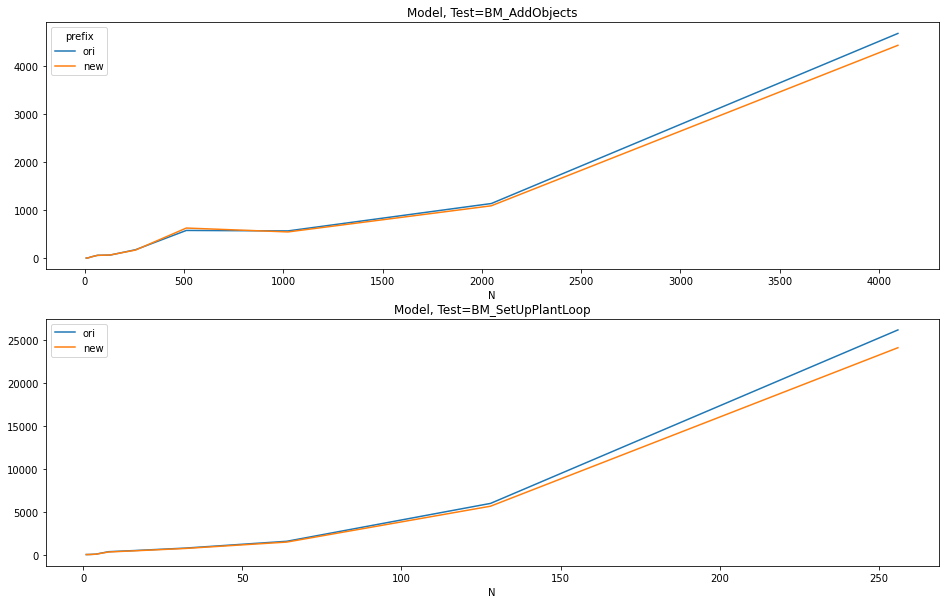

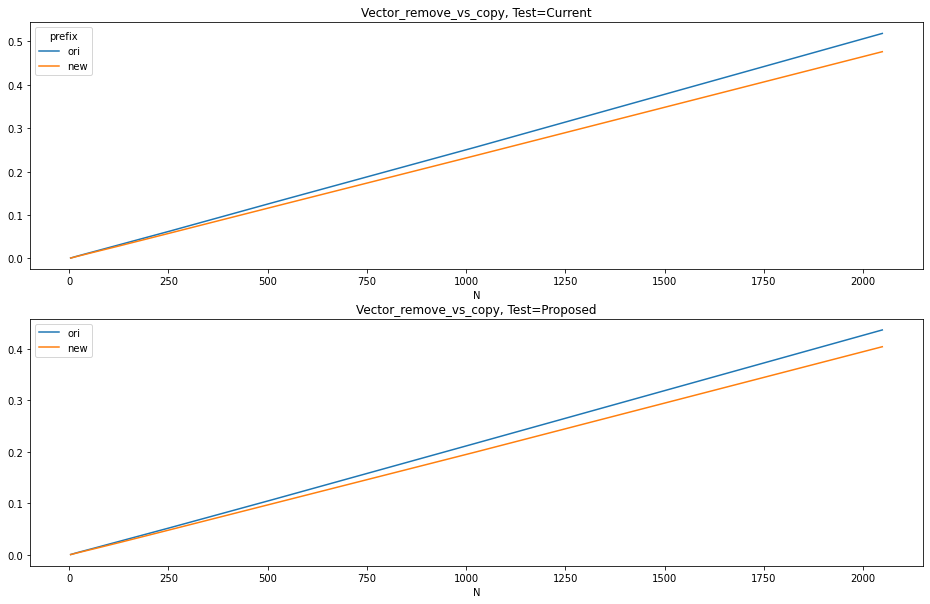

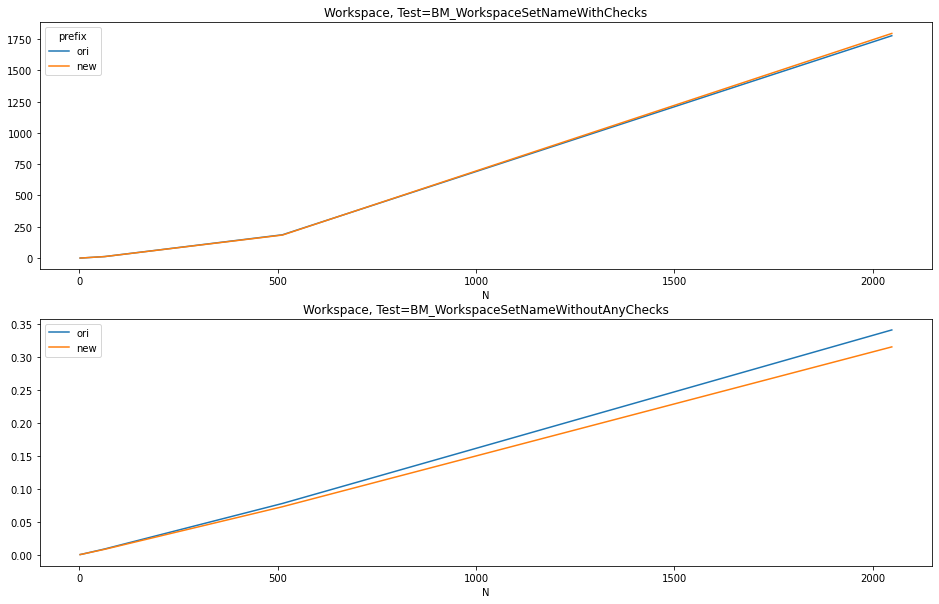

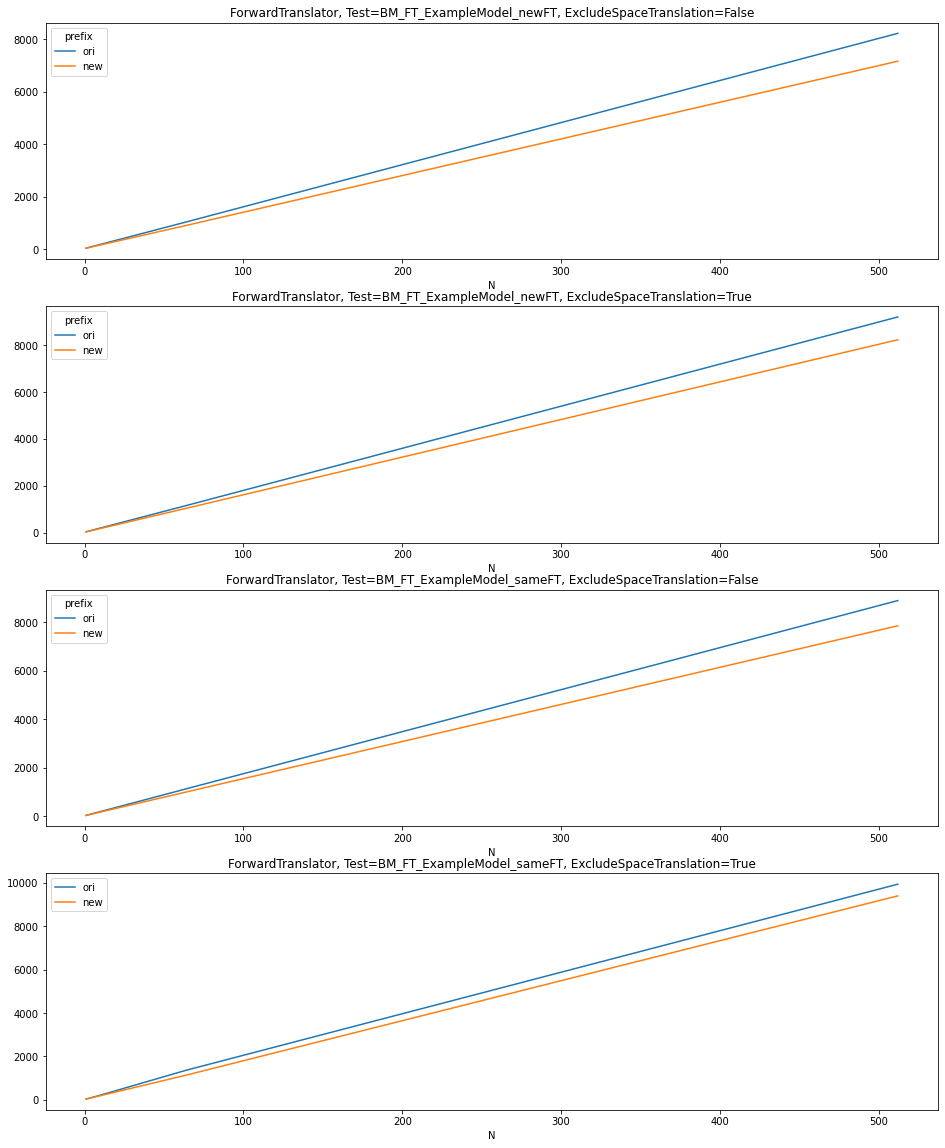

In [18]:
for test_file in test_files:
    toplot = df_real.swaplevel(0, 1, axis=0).loc[test_file, cols]
    toplot.index = toplot.index.str.split('/', expand=True)
    toplot.index = toplot.index.set_levels(level=1, levels=toplot.index.levels[1].astype(int))
    names = ['Test', 'N']
    groupby = ['Test']
    if test_file == 'ForwardTranslator':
        toplot.index = toplot.index.set_levels(level=2, levels=toplot.index.levels[2].astype(int).astype(bool))
        names.insert(-1, 'ExcludeSpaceTranslation')
        groupby.append('ExcludeSpaceTranslation')
        toplot.index = toplot.index.swaplevel(-1, 1)
    elif test_file == 'Model_ModelObjects':
        toplot = toplot.loc[['Current']]
    toplot.index.names = names
    
    toplot.sort_index(inplace=True)
    #toplot.plot(kind='barh')

    grouped = toplot.groupby(groupby)

    ncols = 1
    nrows = int(np.ceil(grouped.ngroups/ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*5), sharey=False)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    
    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        grouped.get_group(key).loc[key].plot(ax=ax)
        title = f'{test_file}'
        if isinstance(key, str):
            key = [key]
        for k,v in zip(groupby, key):
            title += f', {k}={v}'
        ax.set_title(title)

    ax.legend()
    plt.show()

# Plot categorical stuff

In [19]:
df_real

,prefix,ori,new
name,test_file,,
BM_AddObjects/1024,Model,569.100000,547.906000
BM_AddObjects/128,Model,67.722300,69.237400
BM_AddObjects/16,Model,7.873060,7.584890
BM_AddObjects/2048,Model,1136.940000,1089.970000
BM_AddObjects/256,Model,178.573000,171.856000
...,...,...,...
Proposed/32,Vector_remove_vs_copy,0.006893,0.006194
Proposed/4,Vector_remove_vs_copy,0.000884,0.000785
Proposed/512,Vector_remove_vs_copy,0.107246,0.099457


In [20]:
df_real.swaplevel(0, 1, axis=0).loc['VersionTranslation', cols]

prefix,ori,new
name,,
BM_LoadIdfFile/Model12,1673.92000,1674.110000
BM_LoadIdfFile/Windows_Complete,2372.34000,2356.790000
BM_LoadIdfFile/example_1_13_4,1202.00000,1131.270000
BM_LoadIdfFile/example_1_14_0,258.20600,258.252000
BM_LoadIdfFile/floorplan_school,112.79800,113.432000
BM_LoadIdfFile/seb,560.89500,558.158000
BM_LoadIdfFile/two_stories_pre_intersect,3.57178,3.515769


In [21]:
df_real.index.get_level_values(1).unique()

Index(['Model', 'ThermalZoneCombineSpaces', 'ForwardTranslator',
       'IdfFileGetObjects', 'LoadIdfFile', 'VersionTranslation',
       'IdfObjectParse', 'LoadIdd', 'IddObjectParse', 'Workspace',
       'Model_ModelObjects', 'Vector_remove_vs_copy'],
      dtype='object', name='test_file')

<AxesSubplot:ylabel='test_file,name'>

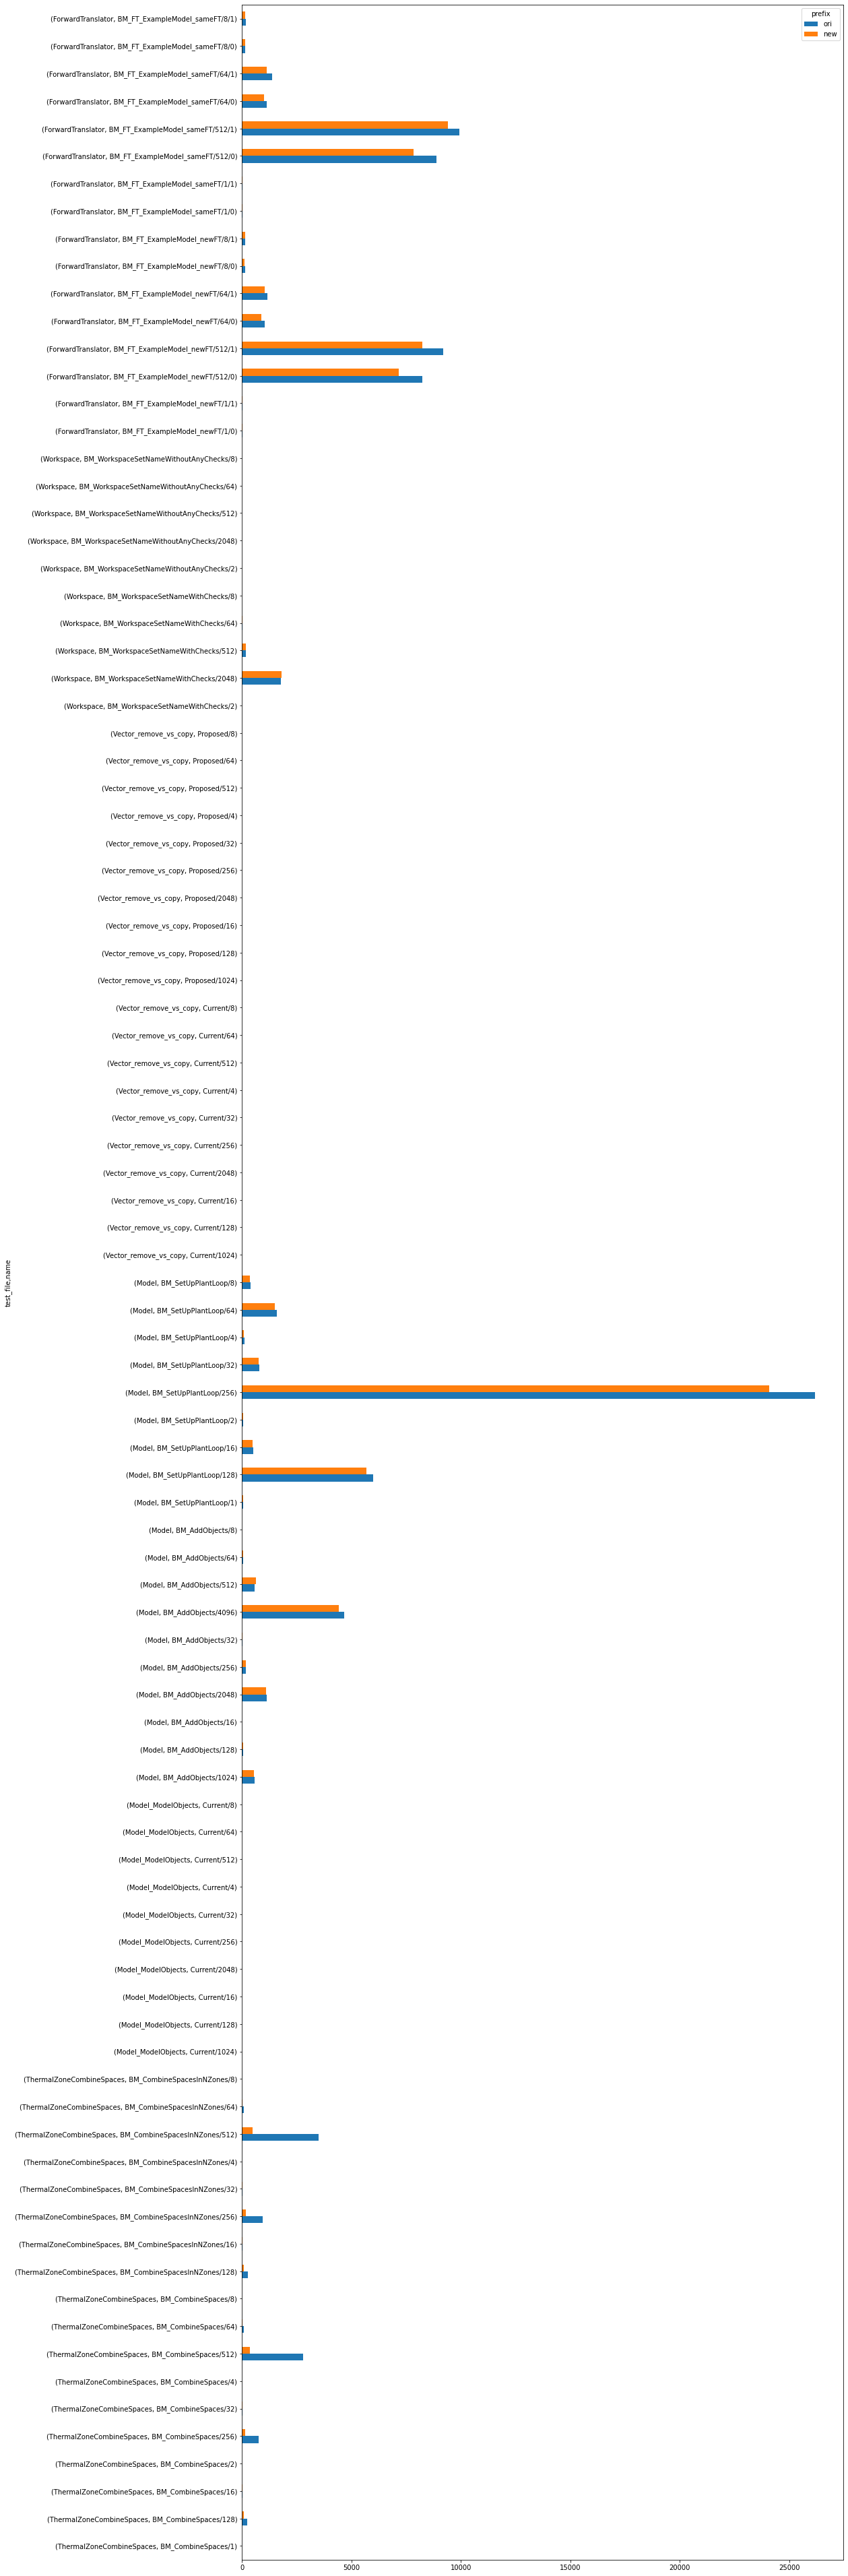

In [22]:
toplot = df_real.swaplevel(0, 1, axis=0).loc[test_files, cols]
toplot.plot(kind='barh', figsize=(16, 0.75*toplot.shape[0]))

LoadIdfFile
VersionTranslation
IdfObjectParse
LoadIdd


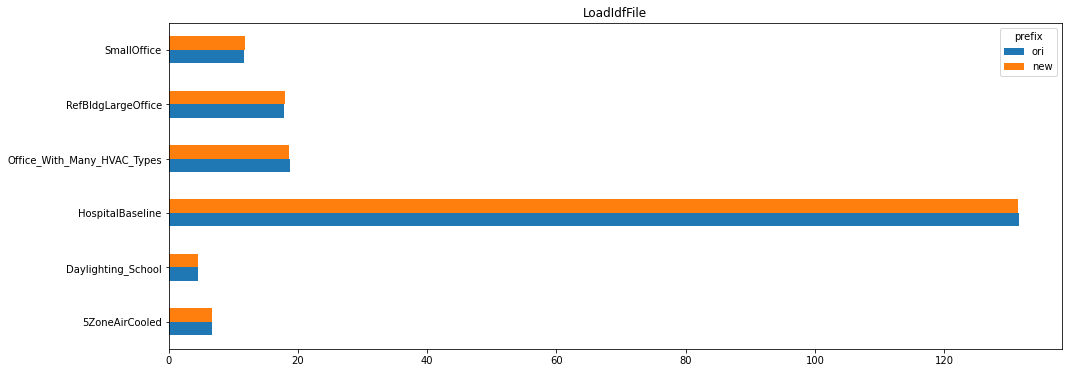

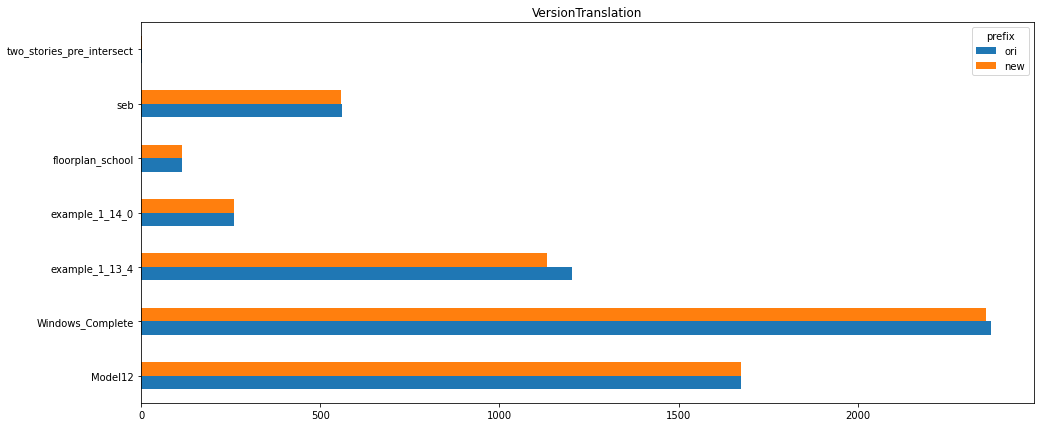

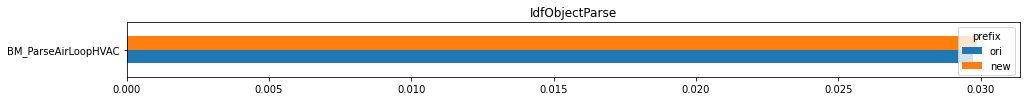

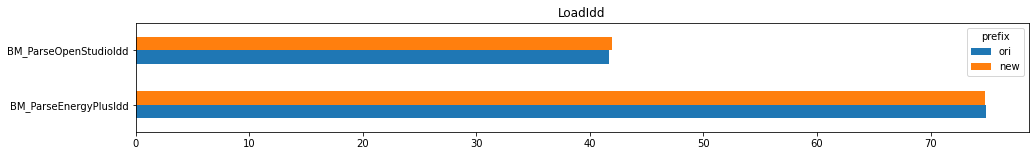

In [23]:
test_files = ['LoadIdfFile', 'VersionTranslation', 'IdfObjectParse', 'LoadIdd']
test_file = test_files[0]
for test_file in test_files:
    print(test_file)
    toplot = df_real.swaplevel(0, 1, axis=0).loc[test_file, cols]
    toplot.index = toplot.index.str.split('/', expand=True)
    if toplot.index.nlevels > 1 and toplot.index.levels[0].size == 1:
        toplot.index = toplot.index.droplevel(level=0)
    if toplot.index.nlevels > 1 and toplot.index.levels[1].size == 1:
        toplot.index = toplot.index.droplevel(level=1)
    if toplot.index.nlevels > 1:
        raise
        
    fig, ax = plt.subplots(figsize=(16, 1*toplot.shape[0]))
    toplot.plot(kind='barh', ax=ax)
    ax.set_title(test_file)


<AxesSubplot:ylabel='name'>

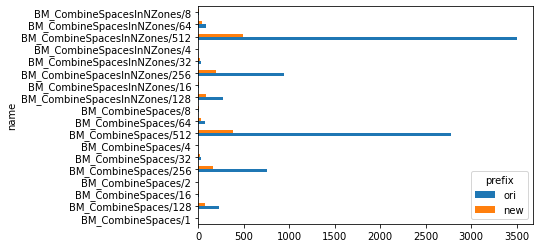

In [24]:
df_real.swaplevel(0, 1, axis=0).loc['ThermalZoneCombineSpaces', ['ori', 'new']].plot(kind='barh')